#Setup

In [ ]:
from os.path import join
import os
import re

from google.colab import drive

import numpy as np

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2


device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/인공지능프로젝트/PLSU_4064_flip_rotate.zip" -d "/content/"

# Sorting Data

In [3]:
## 파일 이름에서 숫자 부분을 추출하는 함수
def extract_number(file_name):
    numbers = re.findall(r'\d+', file_name)
    return int(numbers[0]) if numbers else 0


def list_files_in_directory(directory_path):
    items_in_directory = sorted(os.listdir(directory_path))
    files_in_directory = [item for item in items_in_directory if os.path.isfile(os.path.join(directory_path, item))]

    return files_in_directory

In [ ]:
# 이미지와 마스크 파일 경로 가져오기 및 정렬
mask_directory = '/content/PLSU_4064_flip_rotate/Mask'
mask_files = list_files_in_directory(mask_directory)
sorted_mask_files = sorted(mask_files, key=extract_number)
print(sorted_mask_files)
print(len(sorted_mask_files))



image_directory = '/content/PLSU_4064_flip_rotate/img'
image_files = list_files_in_directory(image_directory)
sorted_image_files = sorted(image_files, key=extract_number)
print(sorted_image_files)
print(len(sorted_image_files))



# 이미지와 마스크 파일의 전체 경로 생성
image_paths = [os.path.join(image_directory, file_name) for file_name in sorted_image_files]
mask_paths = [os.path.join(mask_directory, file_name) for file_name in sorted_mask_files]



# 이미지와 마스크의 경로 예시를 보고 혹시 파일 리스트가 순서대로 정렬되어 있지 않는지 확인해봅니다.
print(f'이미지 경로 예시 : {image_paths[:5]}')
print(f'마스크 경로 예시 : {mask_paths[:5]}')

# Custom Dataset

In [5]:
from torch.utils.data import Dataset
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

class PalmDataset(Dataset):
    def __init__(self, image_paths, mask_paths, size=(256, 256), mode='train'):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.resize = size
        self.mode = mode

        # 기본 변환: 모든 모드에 적용
        base_transform = [
            A.Resize(*size),
            A.Normalize(),
            ToTensorV2()
        ]

        transform = [
            A.Resize(*size),
            ToTensorV2()
        ]
        self.normal_transform = A.Compose(transform)

        # Train 모드에만 적용될 추가적인 데이터 증강 변환
        if mode == 'train':
            self.transform = A.Compose([
                # data augmentation 적는 곳
            ] + base_transform)
        else:
            # Validation 및 Test 모드에서는 기본 변환만 적용
            self.transform = A.Compose(base_transform)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = mask / 255  # Normalize the mask to be [0, 1]

        # 변환 적용
        augmented = self.transform(image=image, mask=mask)
        augmented2 = self.normal_transform(image=image, mask=mask)
        return augmented['image'], augmented['mask'], augmented2['image']


# Data Lodaer

In [6]:
#train:val:test = 75%:15%:15%
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)
test_image_paths, val_image_paths, test_mask_paths, val_mask_paths = train_test_split(test_image_paths, test_mask_paths, test_size=0.5, random_state=42)

train_dataset = PalmDataset(train_image_paths, train_mask_paths, size=(256,256),mode='train')
val_dataset = PalmDataset(val_image_paths, val_mask_paths, size=(256,256),mode='val')
test_dataset = PalmDataset(test_image_paths, test_mask_paths, size=(256,256),mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [1]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


# Define Model

In [7]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, dim, depth, heads, mlp_dim, pool = 'cls', channels = 512, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()


    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.vit = ViT(image_size = 32,patch_size = 8,dim = 2048, depth = 2, heads = 16,mlp_dim = 12,channels = 512) #dim%head=0
        self.vit_conv = nn.Conv2d(32,512,kernel_size = 1,padding = 0) #to increase the number of channels
        self.vit_linear = nn.Linear(64,1024)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        #applying Vision Transformer
        x6 = self.vit(x5) #[4,2048]
        x6 = torch.reshape(x6,(-1,32,8,8)) #[4,32,8,8]
        x7 = self.vit_conv(x6) #[4,512,8,8]
        x8 = self.vit_linear(torch.reshape(x7,(-1,512,64))) #[4,512,1024]
        x9 = torch.reshape(x8,(-1,512,32,32))

        x = self.up1(x9, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

#Evaluate

In [8]:
# F-1 Score와 IoU 계산을 위한 함수
def calculate_f1_score(preds, labels):
    # 시그모이드 함수를 적용하여 확률로 변환
    preds = torch.sigmoid(preds)
    # 확률을 이진화 (0.5를 임계값으로 사용)
    preds = (preds > 0.5).float()

    # True Positives, False Positives, False Negatives 계산
    tp = (preds * labels).sum(dim=[1, 2, 3])
    fp = (preds * (1 - labels)).sum(dim=[1, 2, 3])
    fn = ((1 - preds) * labels).sum(dim=[1, 2, 3])

    # F1 Score 계산
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    # 배치 내 모든 이미지에 대한 F1 Score의 평균 반환
    return f1.mean().item()

def calculate_iou(preds, labels):
    # 시그모이드 함수를 적용하여 확률로 변환
    preds = torch.sigmoid(preds)
    # 확률을 이진화 (0.5를 임계값으로 사용)
    preds = (preds > 0.5).float()

    # True Positives, False Positives, False Negatives 계산
    intersection = (preds * labels).sum(dim=[1, 2, 3])  # 교집합
    total = (preds + labels).sum(dim=[1, 2, 3])  # 합집합
    union = total - intersection  # 합집합 - 교집합

    # IoU 계산
    iou = (intersection + 1e-6) / (union + 1e-6)  # 0으로 나누는 것을 방지하기 위한 작은 값 추가

    # 배치 내 모든 이미지에 대한 IoU의 평균 반환
    return iou.mean().item()


# Loss function

In [9]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

#Train

100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 1, Loss: 0.9548787260323428, Validation Loss: 0.9070940554141999, Avg F-1: 0.495524100959301, mIoU: 0.3325237601995468


100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


Epoch 2, Loss: 0.6260325031334095, Validation Loss: 0.5274204909801483, Avg F-1: 0.6415093600749969, mIoU: 0.4791875764727592


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Epoch 3, Loss: 0.47975577866093494, Validation Loss: 0.4864256501197815, Avg F-1: 0.6784583389759063, mIoU: 0.5178537130355835


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 4, Loss: 0.4554751495297035, Validation Loss: 0.4842684894800186, Avg F-1: 0.6832142412662506, mIoU: 0.522552365064621


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 5, Loss: 0.4421216657992159, Validation Loss: 0.4415133595466614, Avg F-1: 0.7164187073707581, mIoU: 0.5614667236804962


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 6, Loss: 0.43323357453506983, Validation Loss: 0.43059110045433047, Avg F-1: 0.7247924447059632, mIoU: 0.571098992228508


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 7, Loss: 0.4280504704861159, Validation Loss: 0.42822597920894623, Avg F-1: 0.726028323173523, mIoU: 0.5730577737092972


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 8, Loss: 0.4213567188616549, Validation Loss: 0.42265633046627044, Avg F-1: 0.7303004950284958, mIoU: 0.577881982922554


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 9, Loss: 0.41778699132833585, Validation Loss: 0.42444349229335787, Avg F-1: 0.7288904398679733, mIoU: 0.5763775527477264


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Epoch 10, Loss: 0.4168485409758064, Validation Loss: 0.41868876516819, Avg F-1: 0.7328897833824157, mIoU: 0.581166461110115


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch 11, Loss: 0.41010626313391696, Validation Loss: 0.4124759405851364, Avg F-1: 0.7384180426597595, mIoU: 0.5880179762840271


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Epoch 12, Loss: 0.4082734022247657, Validation Loss: 0.42244153618812563, Avg F-1: 0.7298460841178894, mIoU: 0.577792739868164


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 13, Loss: 0.40685891301444405, Validation Loss: 0.41490844190120696, Avg F-1: 0.7356180369853973, mIoU: 0.5845836877822876


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 14, Loss: 0.40303507413756984, Validation Loss: 0.40865514278411863, Avg F-1: 0.7411511927843094, mIoU: 0.5914629071950912


100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 15, Loss: 0.400092235441958, Validation Loss: 0.4074341893196106, Avg F-1: 0.7421963930130004, mIoU: 0.5926992863416671


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 16, Loss: 0.3965817455495341, Validation Loss: 0.40868314206600187, Avg F-1: 0.7404161691665649, mIoU: 0.5905488461256028


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Epoch 17, Loss: 0.3939395948742213, Validation Loss: 0.40696260035037995, Avg F-1: 0.7432239025831222, mIoU: 0.594106650352478


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 18, Loss: 0.39794090959463224, Validation Loss: 0.4224424988031387, Avg F-1: 0.7300657600164413, mIoU: 0.5779121071100235


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 19, Loss: 0.39622739124833867, Validation Loss: 0.4039599925279617, Avg F-1: 0.7444215595722199, mIoU: 0.5956959873437881


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 20, Loss: 0.38969527737478193, Validation Loss: 0.4024058490991592, Avg F-1: 0.7454239517450333, mIoU: 0.5968656212091445


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Epoch 21, Loss: 0.387702550111192, Validation Loss: 0.4009098023176193, Avg F-1: 0.7472454249858856, mIoU: 0.5991345226764679


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 22, Loss: 0.3851843168226521, Validation Loss: 0.4009702980518341, Avg F-1: 0.7469683587551117, mIoU: 0.5987764924764634


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 23, Loss: 0.38248407639814225, Validation Loss: 0.40091085731983184, Avg F-1: 0.7469859778881073, mIoU: 0.5987133711576462


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 24, Loss: 0.3794692105121827, Validation Loss: 0.4001225411891937, Avg F-1: 0.7476482689380646, mIoU: 0.5995495766401291


100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 25, Loss: 0.37636639228027857, Validation Loss: 0.4044861674308777, Avg F-1: 0.7444464832544326, mIoU: 0.5954042136669159


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Epoch 26, Loss: 0.37468812706765164, Validation Loss: 0.39794570207595825, Avg F-1: 0.74913949072361, mIoU: 0.6014176398515702


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 27, Loss: 0.37143318974569944, Validation Loss: 0.3975596636533737, Avg F-1: 0.7493815928697586, mIoU: 0.6018657684326172


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Epoch 28, Loss: 0.36964972166532883, Validation Loss: 0.39614085853099823, Avg F-1: 0.7508551508188248, mIoU: 0.6036511808633804


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 29, Loss: 0.3656290334262205, Validation Loss: 0.3974905401468277, Avg F-1: 0.7498465597629547, mIoU: 0.6024626195430756


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Epoch 30, Loss: 0.36302111322960157, Validation Loss: 0.3961725413799286, Avg F-1: 0.7505545407533646, mIoU: 0.6032105475664139


100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Epoch 31, Loss: 0.36084734589866035, Validation Loss: 0.39558677077293397, Avg F-1: 0.7511504977941513, mIoU: 0.6039747208356857


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 32, Loss: 0.3576986836583427, Validation Loss: 0.39628821313381196, Avg F-1: 0.7507764965295791, mIoU: 0.6035662889480591


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 33, Loss: 0.3558480317672987, Validation Loss: 0.39347660541534424, Avg F-1: 0.7524467319250107, mIoU: 0.6057067155838013


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 34, Loss: 0.35155353720268506, Validation Loss: 0.3934547185897827, Avg F-1: 0.7527871370315552, mIoU: 0.6060774236917496


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Epoch 35, Loss: 0.3485435542095913, Validation Loss: 0.39377432465553286, Avg F-1: 0.7524286657571793, mIoU: 0.6056654393672943


100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Epoch 36, Loss: 0.34574727931719146, Validation Loss: 0.3927511781454086, Avg F-1: 0.753489026427269, mIoU: 0.6070222675800323


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 37, Loss: 0.3427105713426397, Validation Loss: 0.39500104188919066, Avg F-1: 0.7512177497148513, mIoU: 0.6042273044586182


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 38, Loss: 0.3401474423622817, Validation Loss: 0.3932731717824936, Avg F-1: 0.7528203040361404, mIoU: 0.6062327057123185


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 39, Loss: 0.3369756983907035, Validation Loss: 0.39355223774909975, Avg F-1: 0.7524071276187897, mIoU: 0.6057223111391068


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 40, Loss: 0.33415749769532277, Validation Loss: 0.39362879991531374, Avg F-1: 0.752393701672554, mIoU: 0.6056717664003373


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch 41, Loss: 0.33176078421346256, Validation Loss: 0.39288834035396575, Avg F-1: 0.7530231297016143, mIoU: 0.6064260125160217


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 42, Loss: 0.329474816161595, Validation Loss: 0.3925213783979416, Avg F-1: 0.753300017118454, mIoU: 0.6068288236856461


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 43, Loss: 0.3280283179175988, Validation Loss: 0.3936324715614319, Avg F-1: 0.7523653507232666, mIoU: 0.6056276351213455


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 44, Loss: 0.32550262936045615, Validation Loss: 0.39280936419963836, Avg F-1: 0.7529943257570266, mIoU: 0.6064461380243301


100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Epoch 45, Loss: 0.32413435919900957, Validation Loss: 0.39282822906970977, Avg F-1: 0.7529014497995377, mIoU: 0.6063463658094406


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 46, Loss: 0.32286318098561145, Validation Loss: 0.39316258430480955, Avg F-1: 0.7526171684265137, mIoU: 0.6060056030750275
Early stopping triggered


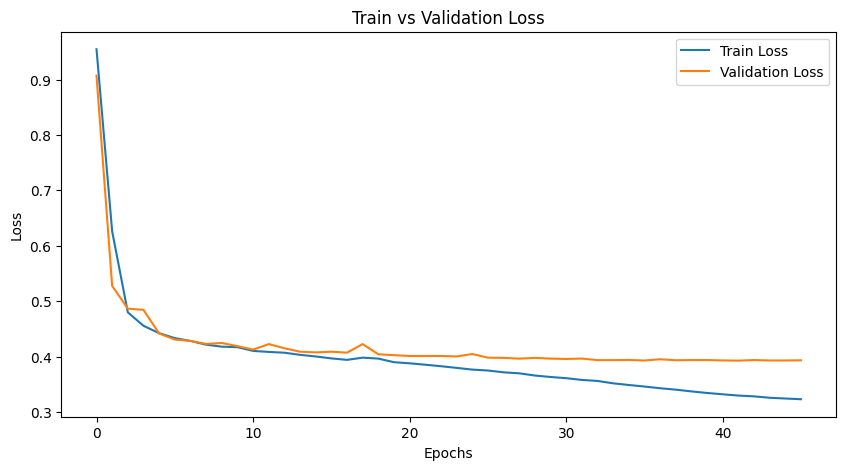

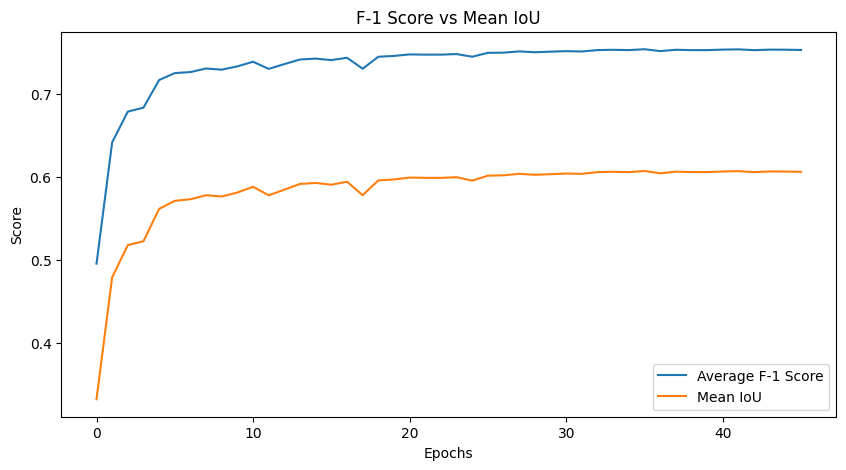

In [10]:
import matplotlib.pyplot as plt

# 성능 기록을 위한 리스트 초기화
train_losses = []
val_losses = []
f1_scores_epochs = []
iou_scores_epochs = []



#하이퍼 파라미터
num_epochs = 50
learning_rate = 0.001
T_max = 50  # 학습률 주기

# 최상의 모델을 저장하기 위한 초기 설정
best_iou_score = 0.0
early_stopping_counter = 0
patience = 10  # 성능이 개선되지 않는 에포크 한계값

# model 초기화
model = UNet(n_channels=3, n_classes=1).to(device)

#loss function과 optimizer 정리
criterion = smp.losses.JaccardLoss(mode='binary')
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4, amsgrad=False)

# CosineAnnealingLR 스케줄러 초기화
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=1e-6)

# training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks, _ in tqdm(train_loader):
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #Learning Rate 조정
    scheduler.step()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0
    iou_scores = []
    f1_scores = []
    with torch.no_grad():
        for images, masks, _ in tqdm(val_loader):  # val_loader는 검증 데이터셋에 대한 DataLoader입니다.
            images = images.float().to(device)
            masks = masks.float().to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # F-1 Score와 IoU 계산
            f1 = calculate_f1_score(outputs, masks)
            iou = calculate_iou(outputs, masks)
            f1_scores.append(f1)
            iou_scores.append(iou)

    # 평균 IoU 및 손실 계산
    val_loss /= len(val_loader)
    avg_f1 = np.mean(f1_scores)
    avg_iou = np.mean(iou_scores)
    val_losses.append(val_loss)
    f1_scores_epochs.append(avg_f1)
    iou_scores_epochs.append(avg_iou)


    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}, Validation Loss: {val_loss}, Avg F-1: {avg_f1}, mIoU: {avg_iou}')

    # Early Stopping
    if avg_iou > best_iou_score:
        best_iou_score = avg_iou
        early_stopping_counter = 0
        # 가장 좋은 모델 저장
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

# 학습 및 검증 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

# F-1 Score와 mIoU Score 그래프
plt.figure(figsize=(10, 5))
plt.plot(f1_scores_epochs, label='Average F-1 Score')
plt.plot(iou_scores_epochs, label='Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('F-1 Score vs Mean IoU')
plt.legend()
plt.show()

#Test

In [11]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from PIL import Image

In [12]:
model.load_state_dict(torch.load('./best_model.pth'))

<All keys matched successfully>

In [13]:
#evaluate Test
# 모델을 평가 모드로 설정
model.eval()

# 점수 초기화
total_f1_score = 0.0
total_iou_score = 0.0
num_samples = 0

# 테스트 데이터셋에 대한 루프
for images, masks, _ in test_loader:
    with torch.no_grad():
        # 데이터를 장치에 로드
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)

        # 모델 예측
        outputs = model(images)

        # F1 점수와 IoU 점수 계산
        f1 = calculate_f1_score(outputs, masks)
        iou = calculate_iou(outputs, masks)
        total_f1_score += f1
        total_iou_score += iou
        num_samples += 1

# 평균 F1 점수와 IoU 점수 출력
avg_f1_score = total_f1_score / num_samples
avg_iou_score = total_iou_score / num_samples
print(f"Average F1 Score on Test Set: {avg_f1_score}")
print(f"Average IoU Score on Test Set: {avg_iou_score}")

Average F1 Score on Test Set: 0.7494908392429351
Average IoU Score on Test Set: 0.6017306238412857


#Test 1 | f1: 0.7467237710952759, iou: 0.597493052482605


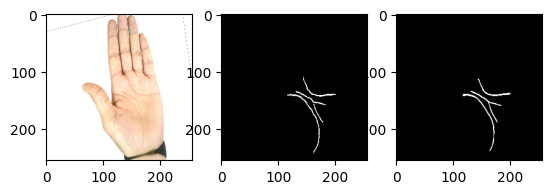

#Test 2 | f1: 0.7404582500457764, iou: 0.5898430347442627


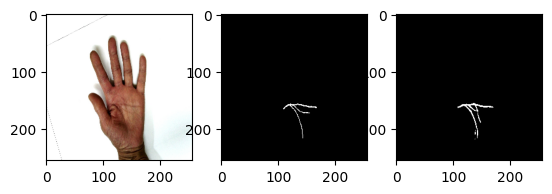

#Test 3 | f1: 0.7557048797607422, iou: 0.6096978187561035


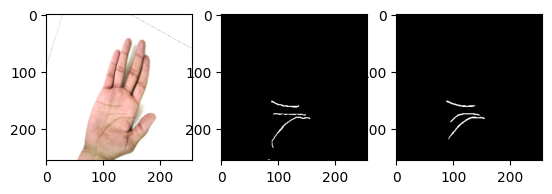

#Test 4 | f1: 0.7502646446228027, iou: 0.603644609451294


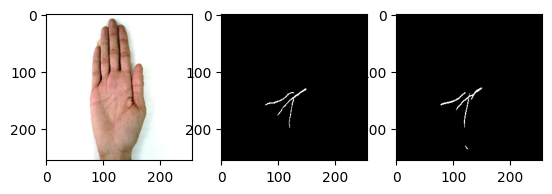

#Test 5 | f1: 0.7672427892684937, iou: 0.6244336366653442


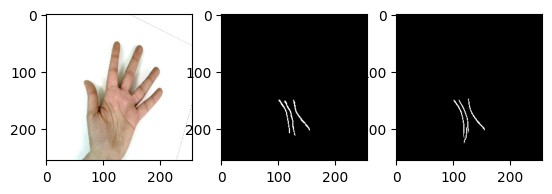

#Test 6 | f1: 0.7446963787078857, iou: 0.595395028591156


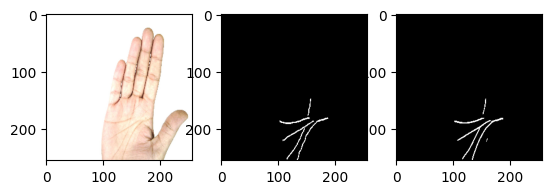

#Test 7 | f1: 0.753488302230835, iou: 0.6071649193763733


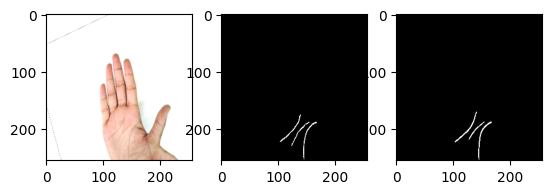

#Test 8 | f1: 0.7539721131324768, iou: 0.607438325881958


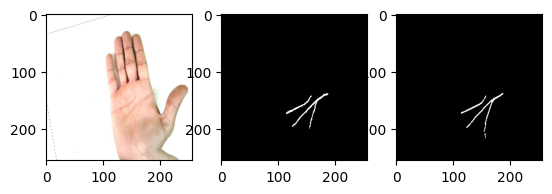

#Test 9 | f1: 0.7417652010917664, iou: 0.5920894145965576


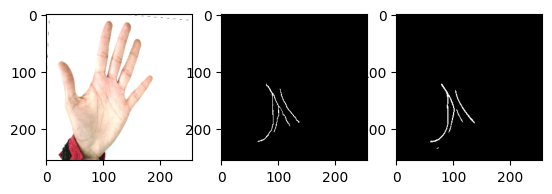

#Test 10 | f1: 0.7542061805725098, iou: 0.6076837778091431


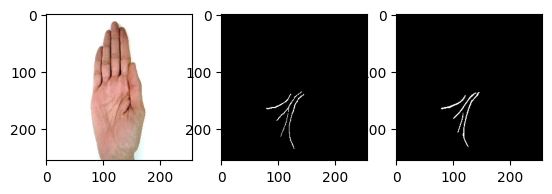

In [14]:
#Print Test Mask
model.eval()

k = 1
f1_scores = []
iou_scores = []
for images, masks, real in test_loader:
    if k > 10:
        break
    with torch.no_grad():
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)
        outputs = model(images)

        # F1와 IoU 계산
        f1 = calculate_f1_score(outputs, masks)
        iou = calculate_iou(outputs, masks)
        f1_scores.append(f1)
        iou_scores.append(iou)

        print(f"#Test {k} | f1: {f1}, iou: {iou}")

        # 시각화
        img_cpu = real[0].cpu().numpy().transpose(1, 2, 0)  # 첫 번째 이미지 선택
        mask_cpu = masks[0].squeeze().cpu().numpy()           # 첫 번째 마스크 선택
        output_sigmoid = torch.sigmoid(outputs[0]).squeeze().cpu().numpy()  # 첫 번째 출력 선택, 채널 차원 제거
        plt.subplot(1, 3, 1)
        plt.imshow(img_cpu)
        plt.subplot(1, 3, 2)
        plt.imshow(mask_cpu, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.imshow(output_sigmoid, cmap='gray')
        plt.show()
        k += 1

#Experiments

In [ ]:
pip install pyheif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 12.4 MB/s eta 0:00:00


In [ ]:
import pyheif

In [ ]:
def heic_to_jpeg(heic_dir, jpeg_dir):

    heif_file = pyheif.read(heic_dir)

    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride
        )

    print(heif_file)
    image.save(jpeg_dir,"JPEG")

In [ ]:
heic_to_jpeg("/content/IMG_5076.heic", "/content/IMG_5076.jpeg")

<HeifFile 2806x3787 RGB with 31931984 bytes data>


In [ ]:
# 단일 이미지에 대한 전처리 및 데이터 증강을 수행하는 함수
def preprocess_image(img_path, size=(256, 256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 데이터 증강 및 전처리 파이프라인
    transform = A.Compose([
        A.Resize(*size),
        A.Normalize(),
        ToTensorV2()
    ])

    # 변환 적용
    transformed = transform(image=image)
    return transformed['image']

In [ ]:
# 단일 이미지를 검출하는 함수
def detect(jpeg_dir, model, device, save=True):
    # 이미지 전처리
    image = preprocess_image(jpeg_dir)

    # 모델 예측
    with torch.no_grad():
        image = image.float().unsqueeze(0).to(device)
        outputs = model(image)

    # 시각화
    pil_img = Image.open(jpeg_dir).convert('RGB').resize((256, 256), resample=Image.NEAREST)
    img_cpu = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    output_sigmoid = torch.sigmoid(outputs).squeeze(0).cpu().numpy().squeeze()  # 첫 번째 차원 제거

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(pil_img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(output_sigmoid, cmap='gray')  # 2차원 배열
    plt.title('Predicted Mask')
    plt.show()

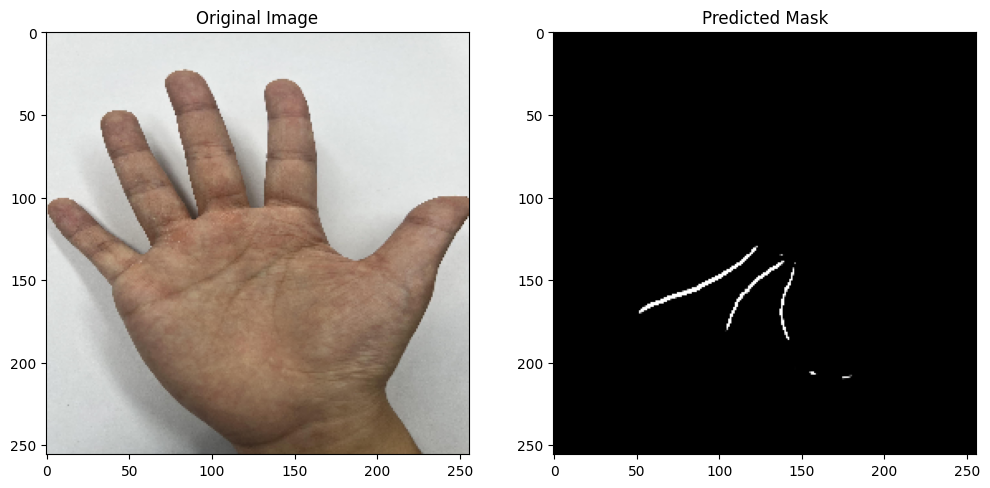

In [ ]:
detect("/content/IMG_5076.jpeg",model,device)

In [ ]:
detect("./inputs/hand2_1.jpeg")
detect("./inputs/hand2_2.jpeg")
detect("./inputs/hand2_3.jpg")
detect("./inputs/hand2_4.jpg")

In [ ]:
detect("./inputs/hand4_1.jpeg")
detect("./inputs/hand4_2.jpeg")
detect("./inputs/hand4_3.jpg")
detect("./inputs/hand4_4.jpg")